# Bayesian estimation of open loop TAR models


In [1]:
import numpy as np
import TAR
import pandas as pd
from scipy.special import gamma, factorial
from scipy.stats import bernoulli
import matplotlib.pyplot as plt
import random

c:\Users\samir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\Users\samir\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:

# Generate TAR series:
y, s = TAR.tar_simulation([2,-0.9], [-2,0.5], 30, sd = 0.5, tau = 0)
dat = pd.DataFrame({"y":[i[0] for i in y], "s_1":s})
dat['x'] = dat["y"].shift(1)
dat.dropna(inplace = True)
dat.drop("s_1", axis=1, inplace = True)
# Some random partition:
dat["s_1"] = [bernoulli.rvs(0.5) for i in range(len(dat))]
orig = dat.copy()

{'Regime_1': 14, 'Regime_2': 16}


In [3]:
dat["s_1"] = np.array(s[1:])
# # dat

In [7]:
def Proportion(dat, row):
    
    ## Keep the original data_0_0 clean by operating on its copy rather than on itself:
    data                =       dat.copy(
    )
    n                   =       len(data
    )

    ## Evaluate the constant if I=1:
    data.loc[row,"s_1"] =       1
    n_1                 =       np.sum(data.s_1)
    
    data["xs_1"]        =       data.x*data.s_1 
    data["s_2"]         =       1 - data.s_1
    data["xs_2"]        =       data["s_2"]*data["x"
    ]
    data["ys_1"]        =       data.y*data.s_1
    data["ys_2"]        =       data.y*data.s_2
 
    # Covariance Matrix of Regressors if I==1 and if I==0:
    Sxx_1               =       data.loc[:, ["s_1", "xs_1"]].T@data.loc[:, ["s_1", "xs_1"       ]
    ]
    Sxx_2               =       data.loc[:, ["s_2", "xs_2"]].T@data.loc[:, ["s_2", "xs_2"       ]
    ]
    inv_1               =       np.linalg.inv(Sxx_1
    )
    inv_2               =       np.linalg.inv(Sxx_2
    )
    det_1               =       np.linalg.det(Sxx_1.to_numpy()
    )
    det_2               =       np.linalg.det(Sxx_2.to_numpy()
    )
    det                 =       det_1*det_2

    # Covariance Matrix of Regressors and the Response (XY) if I==1:
    Sxy_1               =       data.loc[:, ["s_1", "xs_1"]].T@data.ys_1
    Sxy_2               =       data.loc[:, ["s_2", "xs_2"]].T@data.ys_2
    delta_1             =       data.ys_1.T@data.ys_1 - Sxy_1.T@inv_1@Sxy_1
    delta_2             =       data.ys_2.T@data.ys_2 - Sxy_2.T@inv_2@Sxy_2
    
    Q_1                 =       np.log(gamma((n_1 +0.01)/2                                      )
    ) + np.log(gamma((n - n_1 + 0.01)/2                                                         )
    ) - np.log(delta_1**((n_1 - 1 -1)/2))  - np.log(delta_2**((n - n_1 - 1 -1)/2                )
    ) - np.log(0.01 + det**0.5                                                          
    )

################################################################################################
    # When I = 0:
    data_0               =      data.drop(data.columns[3:], axis = 1)
    data_0.loc[row,"s_1"
                    ]    =      0
    n_1                  =      np.sum(data_0.s_1
    )
    data_0["xs_1"]       =      data_0.x*data_0.s_1 
    data_0["xs_1"]       =      data_0.x*data_0.s_1 
    data_0["s_2"]        =      1 - data_0.s_1
    data_0["xs_2"]       =      data_0["s_2"]*data_0["x"
    ]
    data_0["ys_1"]       =      data_0.y*data_0.s_1
    data_0["ys_2"]       =      data_0.y*data_0.s_2
    x_i                  =      data_0.loc[row, ["s_2", "xs_2"]].to_numpy().reshape(-1,1
    )
 
    Sxx_11               =      data_0.loc[:, ["s_1", "xs_1"]].T@data_0.loc[:, ["s_1", "xs_1"   ]
    ]
    Sxx_21               =      data_0.loc[:, ["s_2", "xs_2"]].T@data_0.loc[:, ["s_2", "xs_2"   ]
    ]

    # Recursions for Inverse and Determinant:
    inv_11               =      inv_1 - (inv_1@(x_i@x_i.T)@inv_1)/(x_i.T@inv_1@x_i - 1
    )
    inv_21               =      inv_2 - (inv_2@(x_i@x_i.T)@inv_2)/(x_i.T@inv_2@x_i + 1
    )

########################################################################################################

    det_11               =      abs(det_1*np.linalg.det(x_i.T@inv_1@x_i - 1)
    )
    # print(det_1, np.linalg.det(Sxx_1))
    # print(det_2, np.linalg.det(Sxx_2))
    det_21               =      abs(det_2*np.linalg.det(x_i.T@inv_2@x_i + 1)
    )
    det                  =      det_11*det_21

    # Covariance Matrix of Regressors and the Response (XY) if I==0:
    Sxy_1                =      data_0.loc[:, ["s_1", "xs_1"]].T@data_0.ys_1
    Sxy_2                =      data_0.loc[:, ["s_2", "xs_2"]].T@data_0.ys_2
    delta_1              =      data_0.ys_1.T@data_0.ys_1 - Sxy_1.T@inv_11@Sxy_1
    delta_2              =      data_0.ys_2.T@data_0.ys_2 - Sxy_2.T@inv_21@Sxy_2
    Q_2                  =      np.log(gamma((n_1 +0.01)/2                                          )
    )                    +      np.log(gamma((n - n_1 + 0.01)/2                                     )
    )                    -      np.log(delta_1**((n_1 - 1 -1)/2)                                    
    )                    -      np.log(delta_2**((n - n_1 - 1 -1)/2                                 )
    )                    -      np.log(0.01 + det**0.5                                              )


    # Update
    C                    =       max(Q_1, Q_2
    )
    Q_1                  =       Q_1 - C
    Q_2                  =       Q_2 - C
    p                    =       np.exp(Q_1)/(np.exp(Q_1) + np.exp(Q_2                       )
    )
    data_0.loc[row, 
    "s_1"]               =       bernoulli.rvs(p
    )

    return p, data_0

    


In [15]:
# Proportion(dat, 1)

In [9]:
rows = dat.index.to_list()
probs = pd.DataFrame()
frames = []
ps = []
N = 1000
for j in range(N):
    if j == 0:
        pass
    else:
        frames += [pd.Series(ps, index = rows, name = f"i{j}")]
        ps = []
    random.shuffle(rows)
    for row in rows:
        a = Proportion(dat, row)
        dat = a[1]
        ps.append(a[0])
        if j == N-1 and row == rows[-1]:
            frames += [pd.Series(ps, index = rows, name = f"i{j+1}")]
            probs = pd.concat(frames, axis=1)

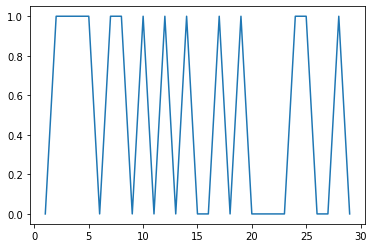

In [13]:
probs.sort_index(inplace=True)
plt.plot(probs.iloc[:,-1])

In [14]:
probs["states"] = np.array(s[1:])
probs

,i1,i2,i3,i4,i5,i6,i7,i8,i9,i10,...,i992,i993,i994,i995,i996,i997,i998,i999,i1000,states
1,0.999989,0.999999,0.999994,9.999733e-01,0.999998,0.999999,0.999994,9.999976e-01,9.999794e-01,9.999745e-01,...,0.999993,9.999972e-01,9.999882e-01,9.999685e-01,9.999845e-01,0.999998,0.999999,9.999603e-01,9.999964e-01,1
2,0.205930,0.000035,0.000020,1.569068e-06,0.000012,0.000011,0.000035,1.225134e-05,4.693590e-05,1.970224e-05,...,0.000034,5.712946e-05,1.242965e-05,1.502399e-04,2.221551e-06,0.000022,0.000057,1.833483e-05,4.587203e-05,0
3,0.000021,0.000042,0.000005,3.092784e-06,0.000005,0.000016,0.000002,5.791343e-06,1.496539e-05,1.097022e-05,...,0.000006,1.202614e-05,3.169092e-06,1.695953e-06,1.021427e-06,0.000005,0.000003,1.216729e-06,1.750982e-06,0
4,0.999999,1.000000,0.999996,9.999742e-01,0.999995,0.999998,0.999995,9.999336e-01,9.999740e-01,9.997409e-01,...,0.999989,9.999953e-01,9.999894e-01,9.999963e-01,9.999795e-01,0.999998,0.999996,9.999755e-01,9.999755e-01,1
5,0.767853,0.261415,0.010996,6.391147e-03,0.005677,0.006874,0.002735,3.894285e-02,1.248979e-02,1.591470e-02,...,0.017127,5.939428e-03,3.728309e-02,7.003663e-03,1.429781e-03,0.021285,0.006623,2.049355e-02,2.049355e-02,0
6,0.000008,0.000008,0.000001,6.411658e-07,0.000002,0.000002,0.000003,6.125880e-07,6.372713e-07,2.891744e-07,...,0.000001,7.411668e-07,4.449551e-07,1.729216e-07,5.968218e-07,0.000002,0.000005,1.408205e-07,1.408205e-07,0
7,1.000000,1.000000,0.999998,9.999880e-01,0.999935,0.999999,0.999996,9.999984e-01,9.999867e-01,9.999603e-01,...,0.999995,9.999976e-01,9.999946e-01,9.999963e-01,9.999880e-01,0.999998,0.999999,9.999887e-01,9.999887e-01,1
8,0.040995,0.040995,0.004621,1.610946e-03,0.000267,0.000188,0.000132,2.613952e-03,7.416777e-04,6.372210e-04,...,0.000666,2.361707e-04,1.886029e-03,1.091806e-03,3.463430e-04,0.000504,0.001315,1.067769e-03,1.318919e-03,0
9,0.999993,0.999991,0.999879,9.993283e-01,0.998902,0.999946,0.999901,9.993326e-01,9.993326e-01,9.994890e-01,...,0.999931,9.998684e-01,9.998764e-01,9.996114e-01,9.995428e-01,0.999921,0.999936,9.997233e-01,9.999260e-01,1
10,0.021513,0.375705,0.369343,3.693427e-01,0.477921,0.541768,0.502676,1.974825e-01,2.966680e-01,2.311729e-01,...,0.539049,5.231313e-01,5.231313e-01,3.942130e-01,3.942130e-01,0.392610,0.450404,3.575434e-01,3.683591e-01,0
